In [1]:
from glob import glob
from astroquery.mast import Mast, Observations
import os
import shutil
import pyavm
import numpy as np
import PIL
import json
import requests
import asdf
import regions
from astropy import log
from astropy.io import ascii, fits
from astropy.wcs import WCS
from astropy import wcs
from astropy.coordinates import SkyCoord
from astropy.utils.data import download_file
from astropy.visualization import ImageNormalize, ManualInterval, LogStretch, LinearStretch
from astropy.visualization import simple_norm
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.table import Table
from astropy.nddata import Cutout2D
import astropy.units as u

# do this before importing webb
os.environ["CRDS_PATH"] = "/orange/adamginsburg/jwst/brick/crds/"
os.environ["CRDS_SERVER_URL"] = "https://jwst-crds.stsci.edu"
from jwst.datamodels import ImageModel

from jwst.pipeline import calwebb_image3
from jwst.pipeline import Detector1Pipeline, Image2Pipeline

from jwst.datamodels import ImageModel

import jwst.datamodels
from jwst import datamodels

In [2]:
cd /orange/adamginsburg/jwst/cloudc/analysis/

/blue/adamginsburg/adamginsburg/jwst/cloudc/code/brick-jwst-2221/analysis


In [3]:
%run selections.py

2024-03-11 13:35:23,516 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/jwst/cloudc/code/brick-jwst-2221/analysis/selections.py:2: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import sys, imp

2024-03-11 13:35:23,654 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/jwst/cloudc/code/brick-jwst-2221/analysis/selections.py:23: DeprecationWarning: `photutils.CircularAperture` is a deprecated alias for `photutils.aperture.CircularAperture` and will be removed in the future. Instead, please use `from photutils.aperture import CircularAperture` to silence this warning.
  from photutils import CircularAperture, EPSFBuilder, find_peaks, CircularAnnulus

2024-03-11 13:35:23,657 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/jwst/cloudc/code/brick-jwst-2221/analysis/selections.py:23: DeprecationWarning: `photutils.EPSFBuilder` is a deprecated alias for `photutils.psf.EPSFBuilder` and will be removed i

I don't want to have to open these if I don't need to.
no daophot stuff done for cloud c yet...
For module nrca catalog crowdsource_nsky0_nrca_photometry_tables_merged.fits, mod date is 2024-03-06 19:50:41
For module nrcb catalog crowdsource_nsky0_nrcb_photometry_tables_merged.fits, mod date is 2024-03-06 22:49:23
For module merged catalog crowdsource_nsky0_merged_photometry_tables_merged.fits, mod date is 2024-03-06 16:35:32
For module merged-reproject catalog crowdsource_nsky0_merged-reproject_photometry_tables_merged.fits, mod date is 2024-03-07 02:34:45
Selecting module merged

NRCA
3798 saturated in near_saturated_f212n_f212n
528 saturated in near_saturated_f466n_f466n
1382 saturated in near_saturated_f405n_f405n
3317 saturated in near_saturated_f187n_f187n
5742 saturated in near_saturated_f182m_f182m
11128 near saturated out of 568994.  That leaves 557866 not near unsaturated
225 saturated in replaced_saturated_f212n
53 saturated in replaced_saturated_f466n
147 saturated in repla

In [4]:
import plot_tools

In [5]:
def get_cutout(filename, position, l, w):
    try: 
        hdu = fits.open(filename, ext='SCI')[0]
    except: 
        hdu = fits.open(filename)[0]
    data = hdu.data
    head = hdu.header

    #pixel_scale = head['PIXSCALE']*u.arcsec/u.pix
    ww = WCS(head)
    size = (l, w)
    #((l/pixel_scale).to(u.pix), (w/pixel_scale).to(u.pix))
    cutout = Cutout2D(data, position=position, size=size, wcs=ww)
    return cutout

def get_cutout_rgb(position, l, w):
    #filename_R = '/orange/adamginsburg/jwst/cloudc/images/F405_reproj_merged-fortricolor.fits'
    filename_R = '/orange/adamginsburg/jwst/cloudc/images/F466_reproj_merged-fortricolor.fits'
    #filename_B = '/orange/adamginsburg/jwst/cloudc/images/F187_reproj_merged-fortricolor.fits'
    filename_B = '/orange/adamginsburg/jwst/cloudc/images/F405_reproj_merged-fortricolor.fits'
    cutout_R = get_cutout(filename_R, position, l, w)
    cutout_B = get_cutout(filename_B, position, l, w)
    cutout_G = cutout_R.data + cutout_B.data
    rgb = np.array(
        [
            cutout_R.data,
            cutout_G,
            cutout_B.data
        ]
    ).swapaxes(0,2).swapaxes(0,1)
    rgb_scaled = np.array([
        simple_norm(rgb[:,:,0], stretch='asinh', min_cut=-1, max_cut=90)(rgb[:,:,0]),
        simple_norm(rgb[:,:,1], stretch='asinh', min_cut=-2, max_cut=210)(rgb[:,:,1]),
        simple_norm(rgb[:,:,2], stretch='asinh', min_cut=-1, max_cut=120)(rgb[:,:,2]),
    ]).swapaxes(0,2)
    return rgb_scaled.swapaxes(0,1), cutout_R.wcs

 
#crds_in = crds_ab[reg.contains(crds_ab, wcs=ww_1)]

In [6]:
crds_base = basetable['skycoord_ref']

# SEDs

(<Figure size 1200x1200 with 12 Axes>,
 (<Quantity [40723.18416882, 21211.92727483, 46540.47722267, 40515.7589144 ,
             18737.2236792 , 18388.83222416, 35074.83347149, 44365.56289462,
             56280.61670395, 75890.53988232,  8788.60126363, 10196.14246306,
             12480.6187239 , 16347.44281361, 21435.2715929 ] Angstrom>,
  <Quantity [ 4262.85790239,   274.27440341,   535.40523943,   454.87184789,
               236.68645057,  2250.8124937 ,  6836.18018646,  8649.92060205,
             12561.17490202, 25288.49843082,   889.45988901,   870.63251373,
              1542.51159452,  2674.06922586,  2793.83342778] Angstrom>,
  <Quantity [0.00286261, 0.00034468, 0.00021866, 0.00035011, 0.00016482,
             0.00065027,        nan,        nan, 0.03620848, 0.08012533,
                    nan,        nan,        nan,        nan, 0.00119386] Jy>,
  <Quantity [       nan,        nan,        nan,        nan,        nan,
                    nan, 0.00100186, 0.00108594,        na

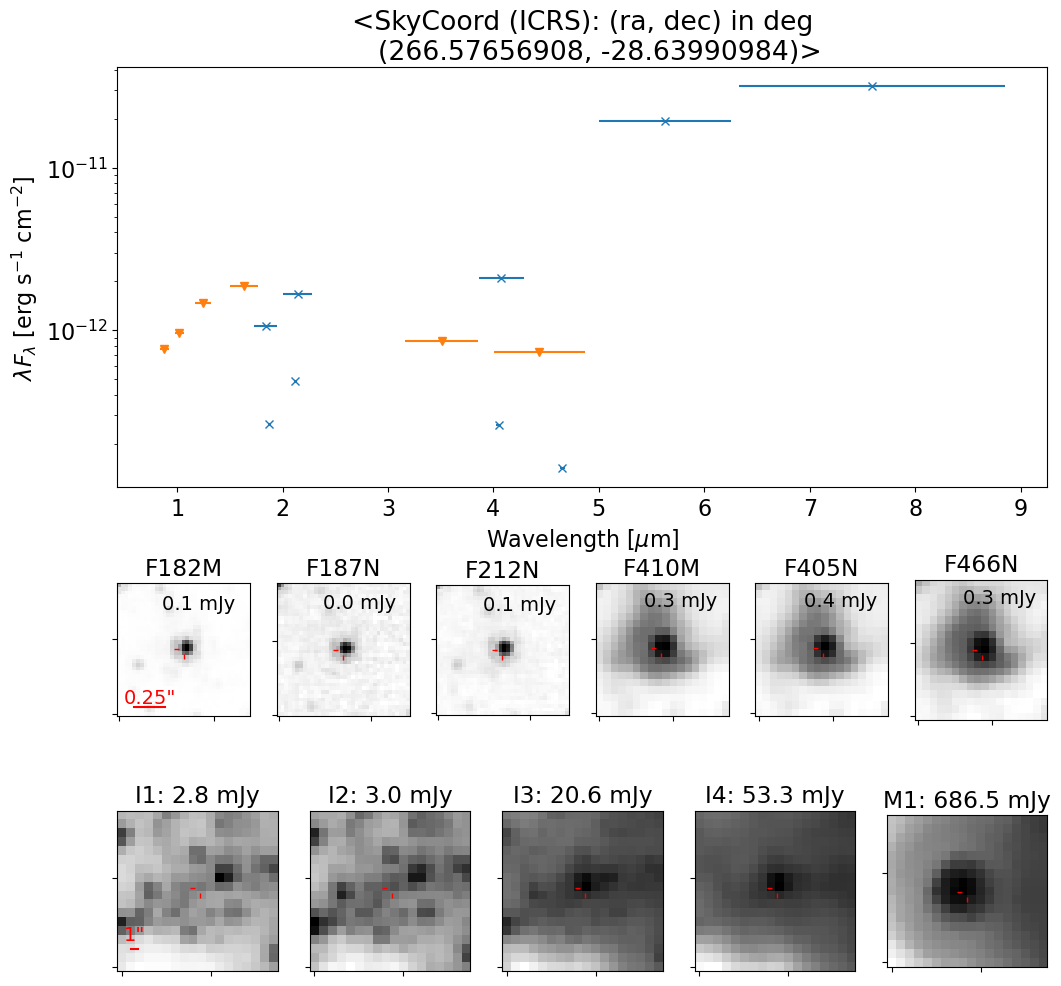

In [7]:
## 88401 YSO Candidate 1
position = SkyCoord('17:46:18.3765780529', '-28:38:23.6754075766', unit=(u.hourangle, u.deg))
plot_tools.sed_and_starzoom_plot(position, basetable, idx=88401, module='merged')

query spitzer
before plotting


(<Figure size 1200x1200 with 12 Axes>,
 (<Quantity [40723.18416882, 21211.92727483, 46540.47722267, 40515.7589144 ,
             18737.2236792 , 18388.83222416, 35074.83347149, 44365.56289462,
             56280.61670395, 75890.53988232,  8788.60126363, 10196.14246306,
             12480.6187239 , 16347.44281361, 21435.2715929 ] Angstrom>,
  <Quantity [ 4262.85790239,   274.27440341,   535.40523943,   454.87184789,
               236.68645057,  2250.8124937 ,  6836.18018646,  8649.92060205,
             12561.17490202, 25288.49843082,   889.45988901,   870.63251373,
              1542.51159452,  2674.06922586,  2793.83342778] Angstrom>,
  <Quantity [0.00000000e+00, 2.61980924e-04, 1.64537254e-04, 4.29063584e-05,
             1.18350654e-04, 5.15825115e-04,            nan,            nan,
                        nan, 6.38807118e-02,            nan,            nan,
             9.55201955e-05, 9.72597167e-04,            nan] Jy>,
  <Quantity [       nan,        nan,        nan,        na

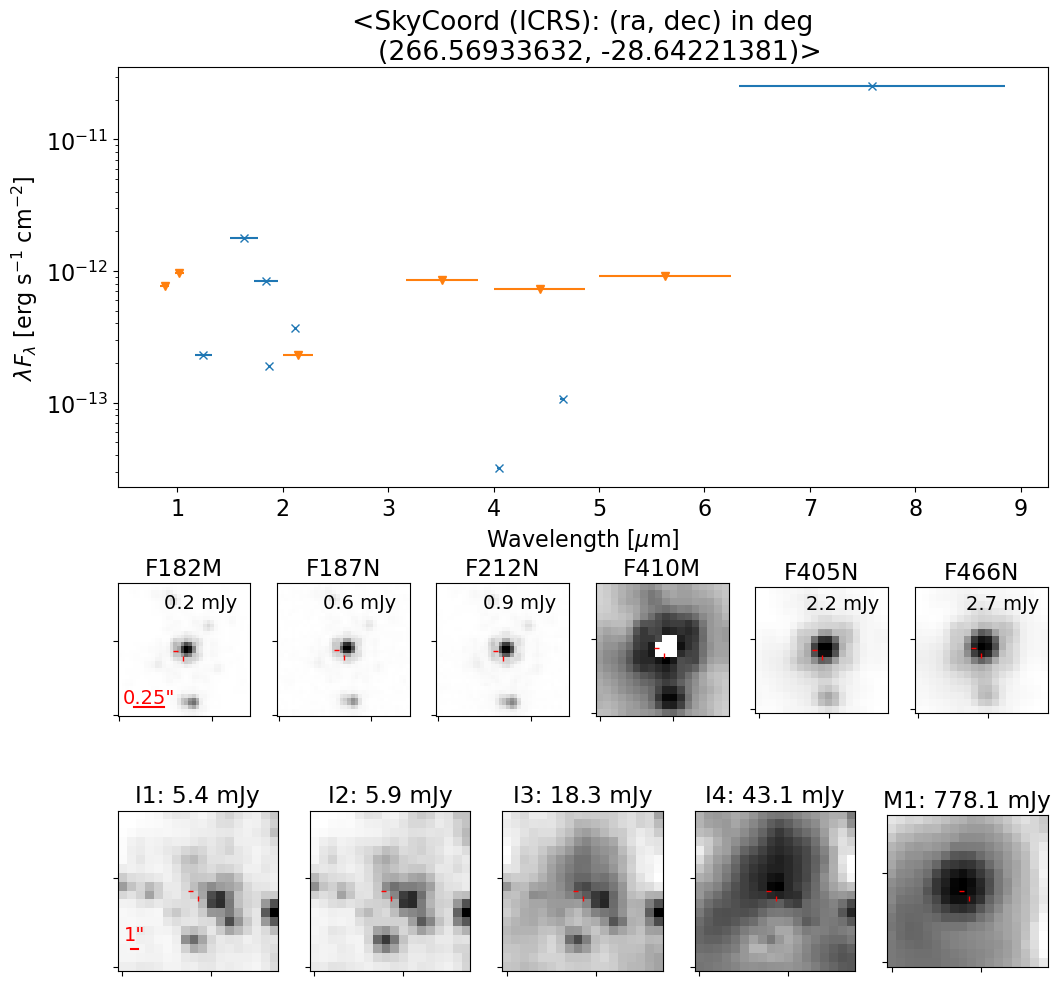

In [8]:
## 105977 YSO Candidate 2
position = SkyCoord('17:46:16.6407156790', '-28:38:31.9696982204', unit=(u.hourangle, u.deg))
plot_tools.sed_and_starzoom_plot(position, basetable, idx=105977, module='merged')

query spitzer
before plotting


(<Figure size 1200x1200 with 12 Axes>,
 (<Quantity [40723.18416882, 21211.92727483, 46540.47722267, 40515.7589144 ,
             18737.2236792 , 18388.83222416, 35074.83347149, 44365.56289462,
             56280.61670395, 75890.53988232] Angstrom>,
  <Quantity [ 4262.85790239,   274.27440341,   535.40523943,   454.87184789,
               236.68645057,  2250.8124937 ,  6836.18018646,  8649.92060205,
             12561.17490202, 25288.49843082] Angstrom>,
  <Quantity [6.84876926e-04, 0.00000000e+00, 0.00000000e+00, 5.60444423e-05,
             0.00000000e+00, 3.86859283e-05, 2.05963361e-03, 2.86548175e-02,
             4.08517458e-02, 8.78556632e-03] Jy>,
  <Quantity [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan] Jy>))

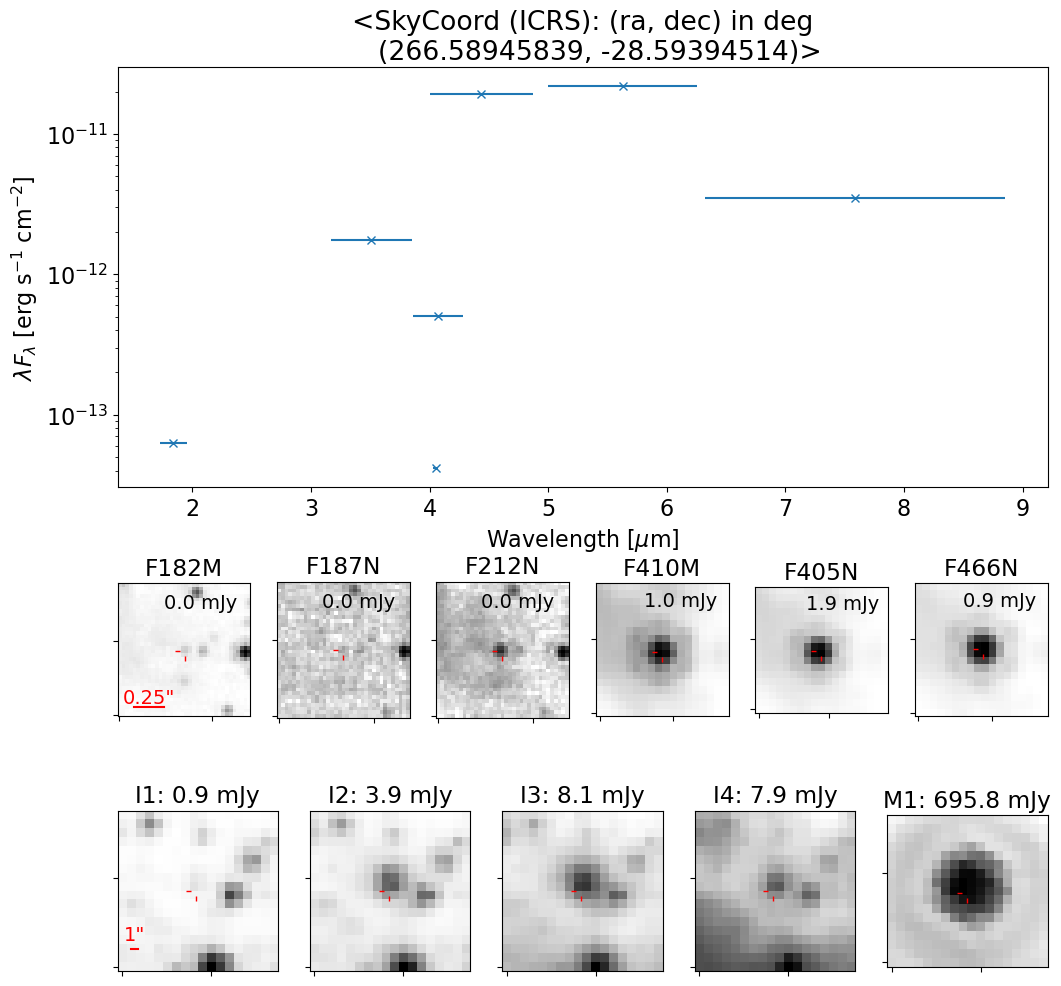

In [10]:
# HMSFR
position = SkyCoord('17:46:21.4700146177', '-28:35:38.2024964716', unit=(u.hourangle, u.deg))
plot_tools.sed_and_starzoom_plot(position, basetable, idx=68636, module='merged')

In [11]:
tbl_uses = basetable[#(~badqflong) #& veryblue_410_466 
                      (basetable['mag_ab_f187n'] - basetable['mag_ab_f182m'] < -.25) 
                     & (basetable['mag_ab_f405n'] - basetable['mag_ab_f410m'] < -.25)]

find relevant coord
query spitzer
before plotting


(<Figure size 1200x1200 with 12 Axes>,
 (<Quantity [40723.18416882, 21211.92727483, 46540.47722267, 40515.7589144 ,
             18737.2236792 , 18388.83222416] Angstrom>,
  <Quantity [4262.85790239,  274.27440341,  535.40523943,  454.87184789,
              236.68645057, 2250.8124937 ] Angstrom>,
  <Quantity [1.39270129e-03, 3.51557042e-04, 3.71227507e-04, 2.29924312e-03,
             4.68229664e-05, 3.64754451e-05] Jy>,
  <Quantity [nan, nan, nan, nan, nan, nan] Jy>))

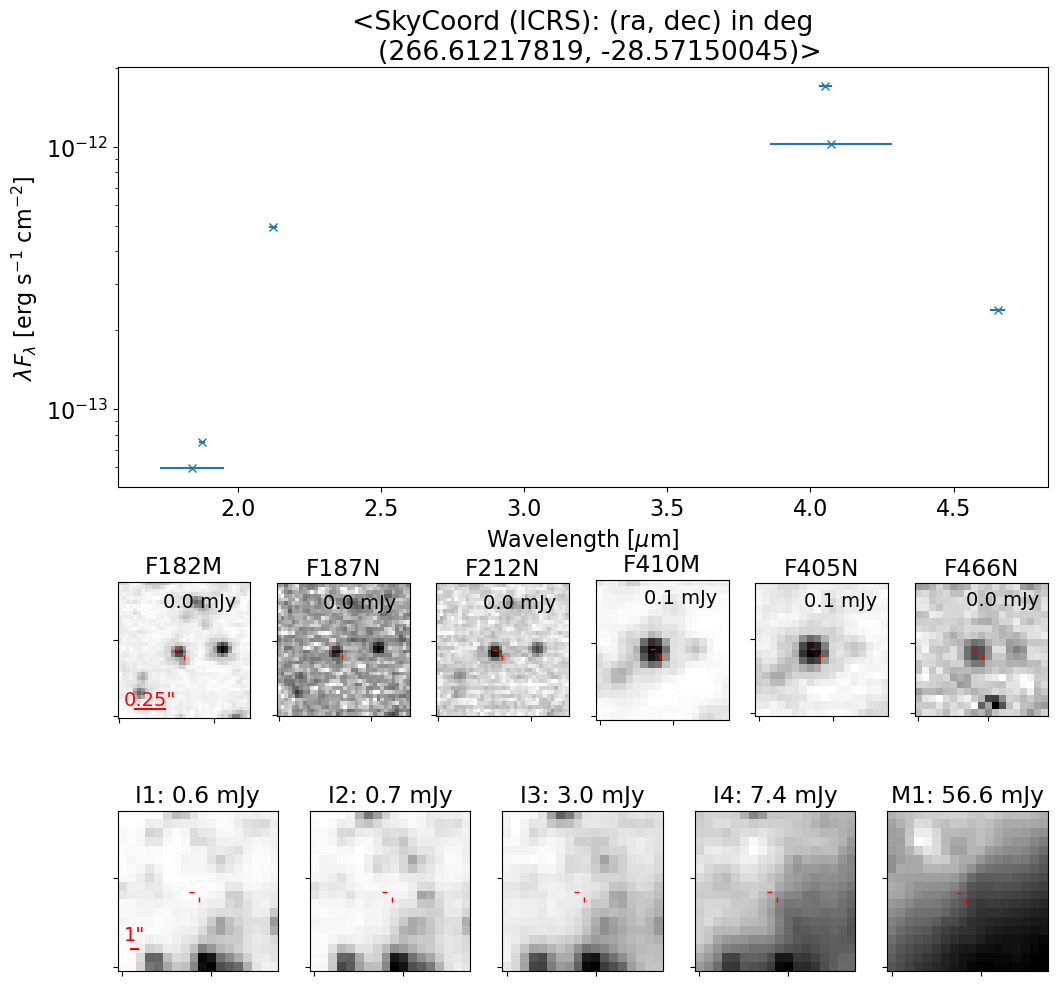

In [14]:
pos = tbl_uses['skycoord_ref'][0]
plot_tools.sed_and_starzoom_plot(pos, basetable, module='merged')

find relevant coord
query spitzer
before plotting


(<Figure size 1200x1200 with 12 Axes>,
 (<Quantity [40723.18416882, 21211.92727483, 46540.47722267, 40515.7589144 ,
             18737.2236792 , 18388.83222416] Angstrom>,
  <Quantity [4262.85790239,  274.27440341,  535.40523943,  454.87184789,
              236.68645057, 2250.8124937 ] Angstrom>,
  <Quantity [2.50578105e-05, 8.40431749e-05, 5.49291377e-04, 1.52665295e-03,
             3.35185141e-05, 4.96934990e-06] Jy>,
  <Quantity [nan, nan, nan, nan, nan, nan] Jy>))

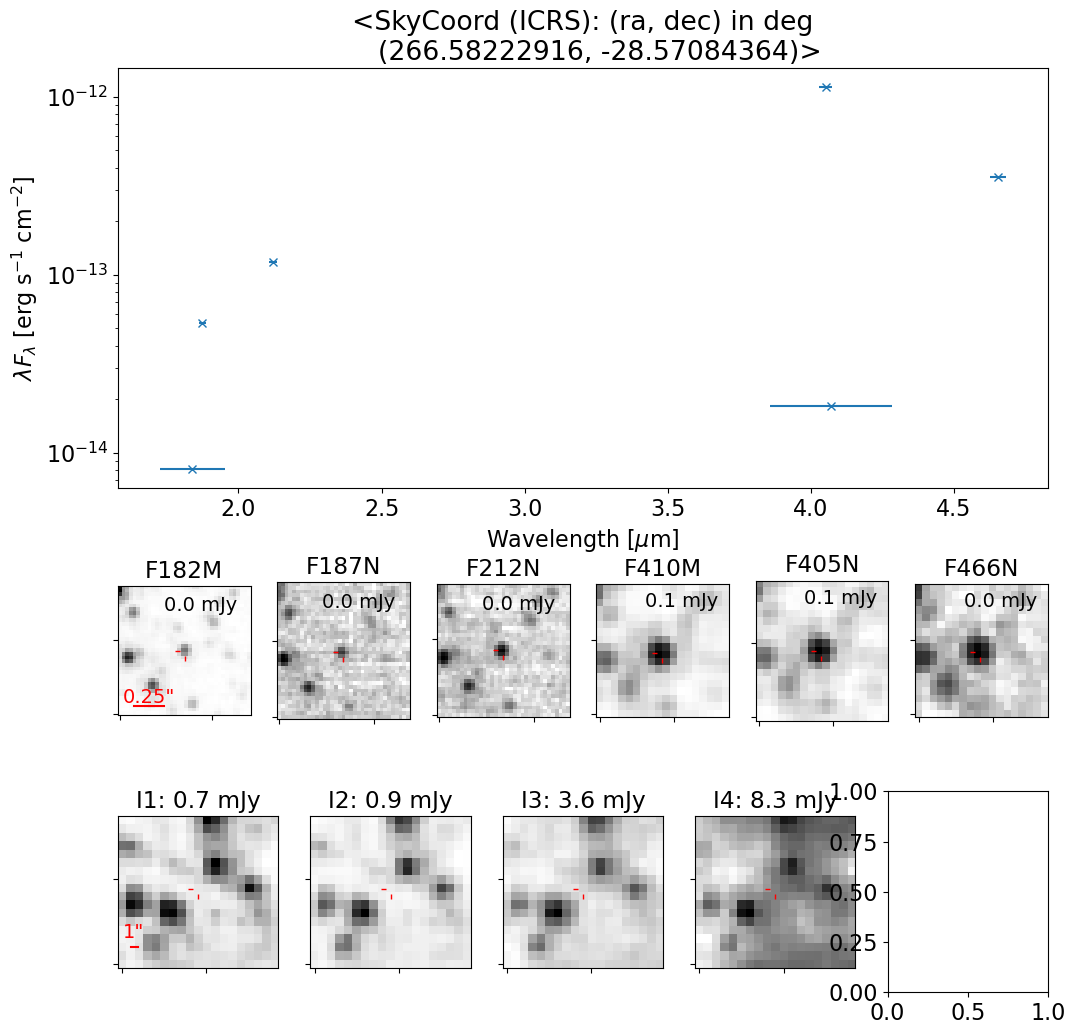

In [16]:
pos = tbl_uses['skycoord_ref'][2]
plot_tools.sed_and_starzoom_plot(pos, basetable, module='merged')

find relevant coord
query spitzer
before plotting


(<Figure size 1200x1200 with 12 Axes>,
 (<Quantity [40723.18416882, 21211.92727483, 46540.47722267, 40515.7589144 ,
             18737.2236792 , 18388.83222416] Angstrom>,
  <Quantity [4262.85790239,  274.27440341,  535.40523943,  454.87184789,
              236.68645057, 2250.8124937 ] Angstrom>,
  <Quantity [0.0001719 , 0.00045261, 0.00034926, 0.00044968, 0.00019892,
             0.00016563] Jy>,
  <Quantity [nan, nan, nan, nan, nan, nan] Jy>))

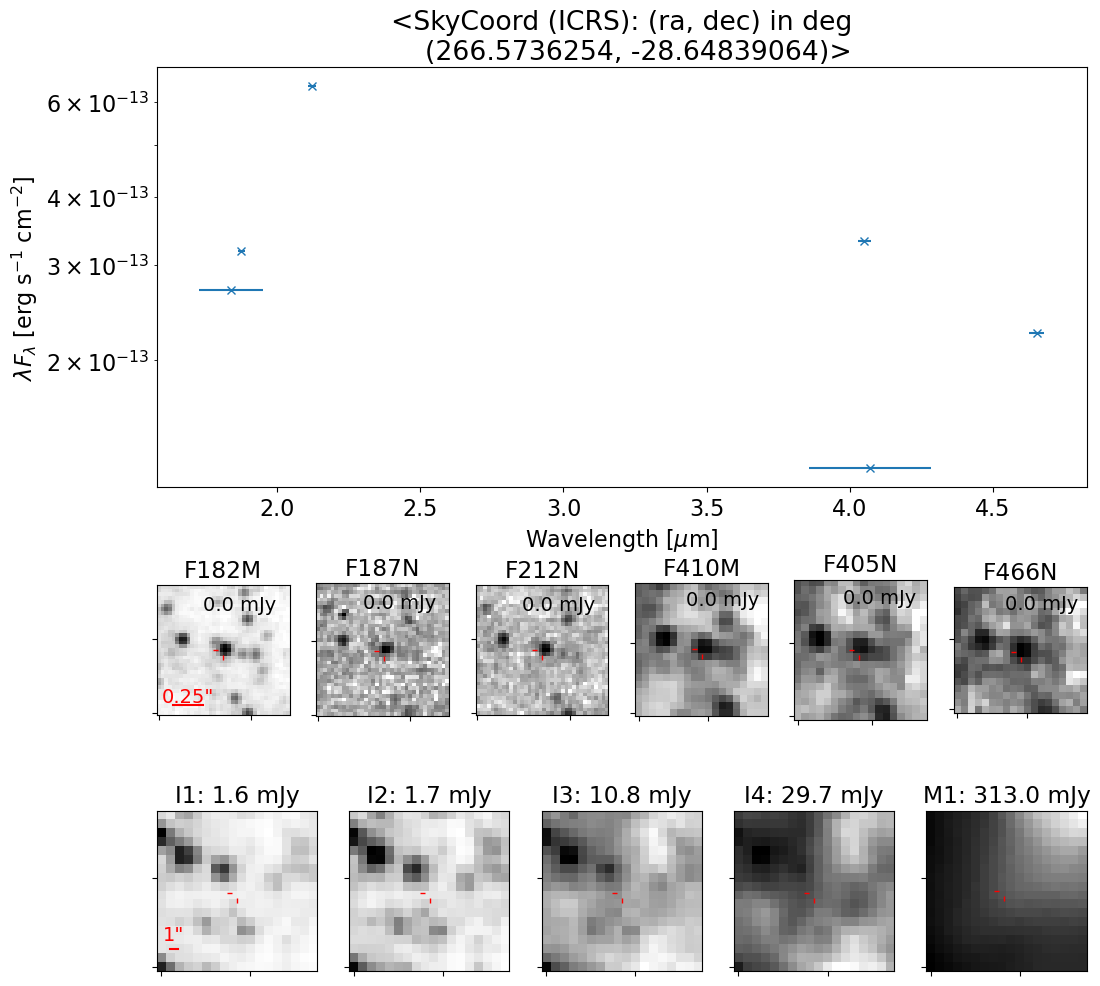

In [18]:
pos = tbl_uses['skycoord_ref'][3]
plot_tools.sed_and_starzoom_plot(pos, basetable, module='merged')

find relevant coord
query spitzer
before plotting


(<Figure size 1200x1200 with 12 Axes>,
 (<Quantity [40723.18416882, 21211.92727483, 46540.47722267, 40515.7589144 ,
             18737.2236792 , 18388.83222416, 35074.83347149, 44365.56289462,
             56280.61670395, 75890.53988232,  8788.60126363, 10196.14246306,
             12480.6187239 , 16347.44281361, 21435.2715929 ] Angstrom>,
  <Quantity [ 4262.85790239,   274.27440341,   535.40523943,   454.87184789,
               236.68645057,  2250.8124937 ,  6836.18018646,  8649.92060205,
             12561.17490202, 25288.49843082,   889.45988901,   870.63251373,
              1542.51159452,  2674.06922586,  2793.83342778] Angstrom>,
  <Quantity [0.00159735, 0.04930928, 0.01200221, 0.01749613, 0.03589954,
             0.        ,        nan,        nan,        nan,        nan,
             0.00278195, 0.00327669, 0.00379223, 0.00403212, 0.00381727] Jy>,
  <Quantity [       nan,        nan,        nan,        nan,        nan,
                    nan, 0.00100186, 0.00108594, 0.0017088

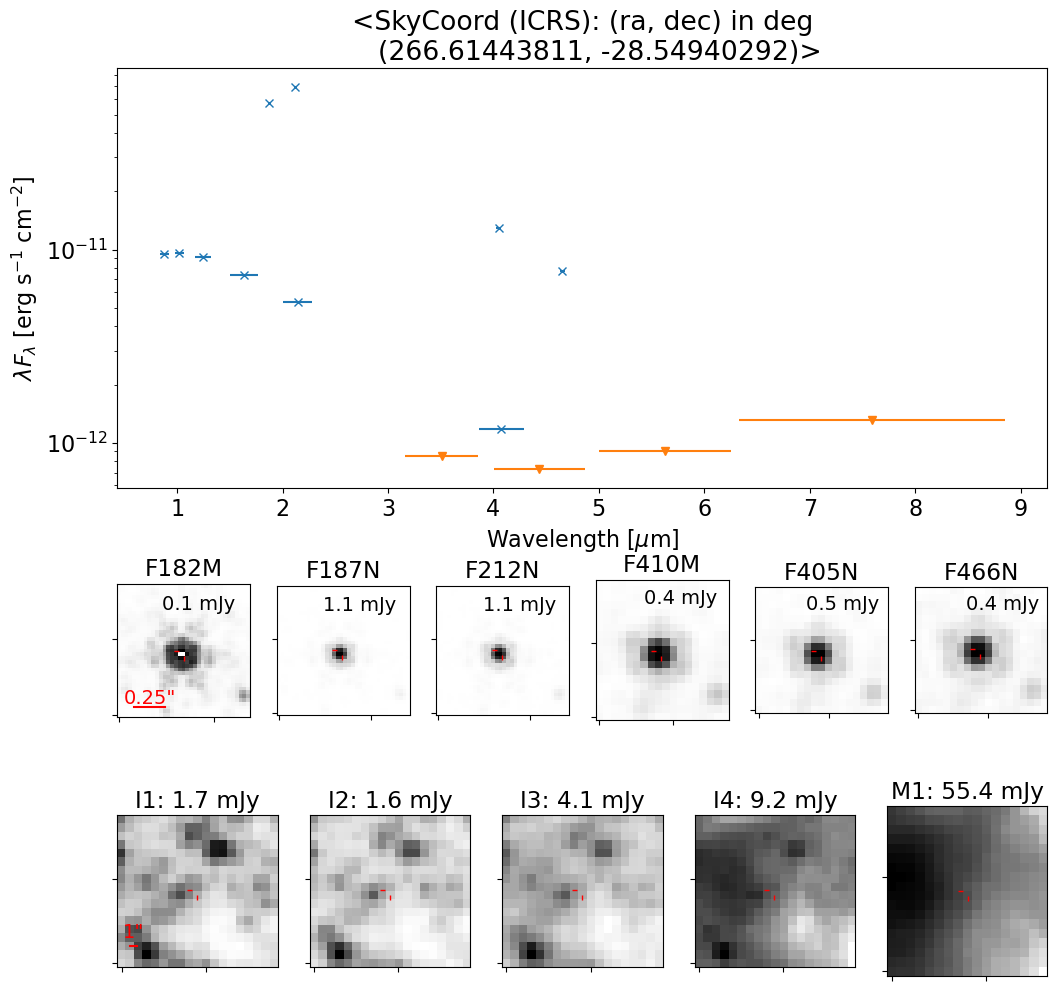

In [19]:
pos = tbl_uses['skycoord_ref'][4]
plot_tools.sed_and_starzoom_plot(pos, basetable, module='merged')

find relevant coord
query spitzer
before plotting


(<Figure size 1200x1200 with 12 Axes>,
 (<Quantity [40723.18416882, 21211.92727483, 46540.47722267, 40515.7589144 ,
             18737.2236792 , 18388.83222416, 35074.83347149, 44365.56289462,
             56280.61670395, 75890.53988232,  8788.60126363, 10196.14246306,
             12480.6187239 , 16347.44281361, 21435.2715929 ] Angstrom>,
  <Quantity [ 4262.85790239,   274.27440341,   535.40523943,   454.87184789,
               236.68645057,  2250.8124937 ,  6836.18018646,  8649.92060205,
             12561.17490202, 25288.49843082,   889.45988901,   870.63251373,
              1542.51159452,  2674.06922586,  2793.83342778] Angstrom>,
  <Quantity [0.00000000e+00, 9.86952800e-05, 1.33474416e-04, 3.30386858e-04,
             2.81258544e-05, 0.00000000e+00, 2.23352131e-03, 3.47054447e-03,
                        nan,            nan,            nan,            nan,
                        nan, 5.11367356e-04, 3.67919540e-03] Jy>,
  <Quantity [       nan,        nan,        nan,        na

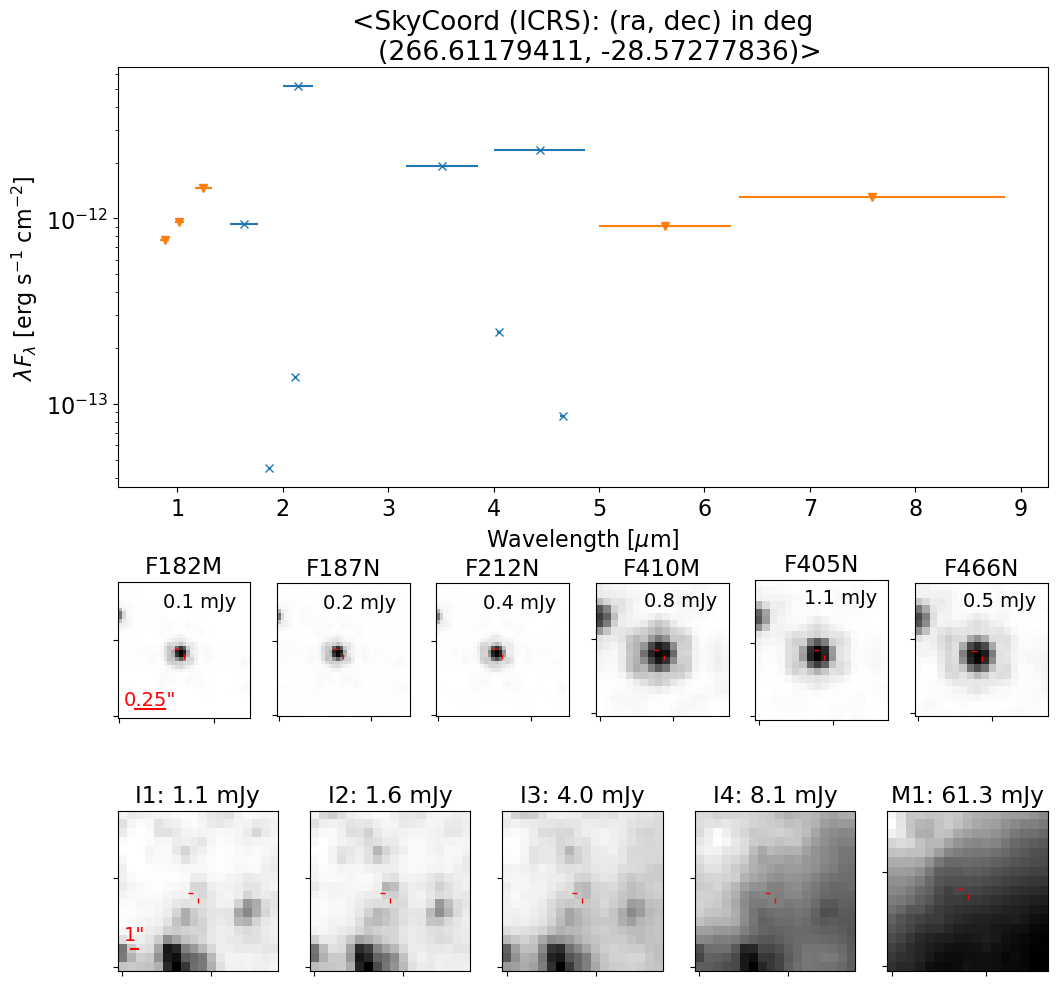

In [20]:
pos = tbl_uses['skycoord_ref'][5]
plot_tools.sed_and_starzoom_plot(pos, basetable, module='merged')

find relevant coord
query spitzer
before plotting


(<Figure size 1200x1200 with 12 Axes>,
 (<Quantity [40723.18416882, 21211.92727483, 46540.47722267, 40515.7589144 ,
             18737.2236792 , 18388.83222416] Angstrom>,
  <Quantity [4262.85790239,  274.27440341,  535.40523943,  454.87184789,
              236.68645057, 2250.8124937 ] Angstrom>,
  <Quantity [0.00018264, 0.00173243, 0.00119814, 0.00165752, 0.00078614,
             0.00036081] Jy>,
  <Quantity [nan, nan, nan, nan, nan, nan] Jy>))

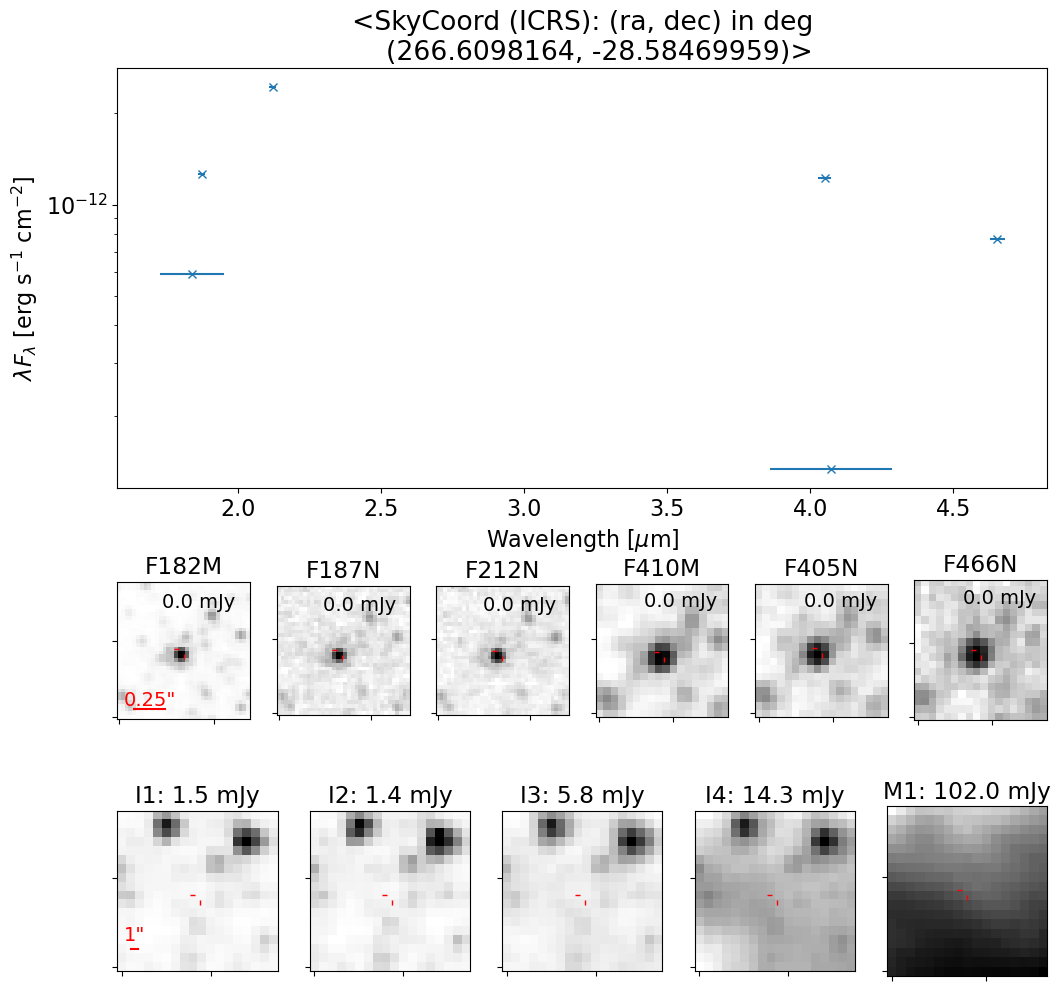

In [21]:
pos = tbl_uses['skycoord_ref'][6]
plot_tools.sed_and_starzoom_plot(pos, basetable, module='merged')

find relevant coord
query spitzer
before plotting


(<Figure size 1200x1200 with 12 Axes>,
 (<Quantity [40723.18416882, 21211.92727483, 46540.47722267, 40515.7589144 ,
             18737.2236792 , 18388.83222416, 35074.83347149, 44365.56289462,
             56280.61670395, 75890.53988232,  8788.60126363, 10196.14246306,
             12480.6187239 , 16347.44281361, 21435.2715929 ] Angstrom>,
  <Quantity [ 4262.85790239,   274.27440341,   535.40523943,   454.87184789,
               236.68645057,  2250.8124937 ,  6836.18018646,  8649.92060205,
             12561.17490202, 25288.49843082,   889.45988901,   870.63251373,
              1542.51159452,  2674.06922586,  2793.83342778] Angstrom>,
  <Quantity [0.04807314, 0.        , 0.03519612, 0.02406358, 0.04746748,
             0.12194043, 0.00485054, 0.00261817, 0.00252354,        nan,
                    nan,        nan, 0.00032247, 0.00232666, 0.0052258 ] Jy>,
  <Quantity [       nan,        nan,        nan,        nan,        nan,
                    nan,        nan,        nan,        na

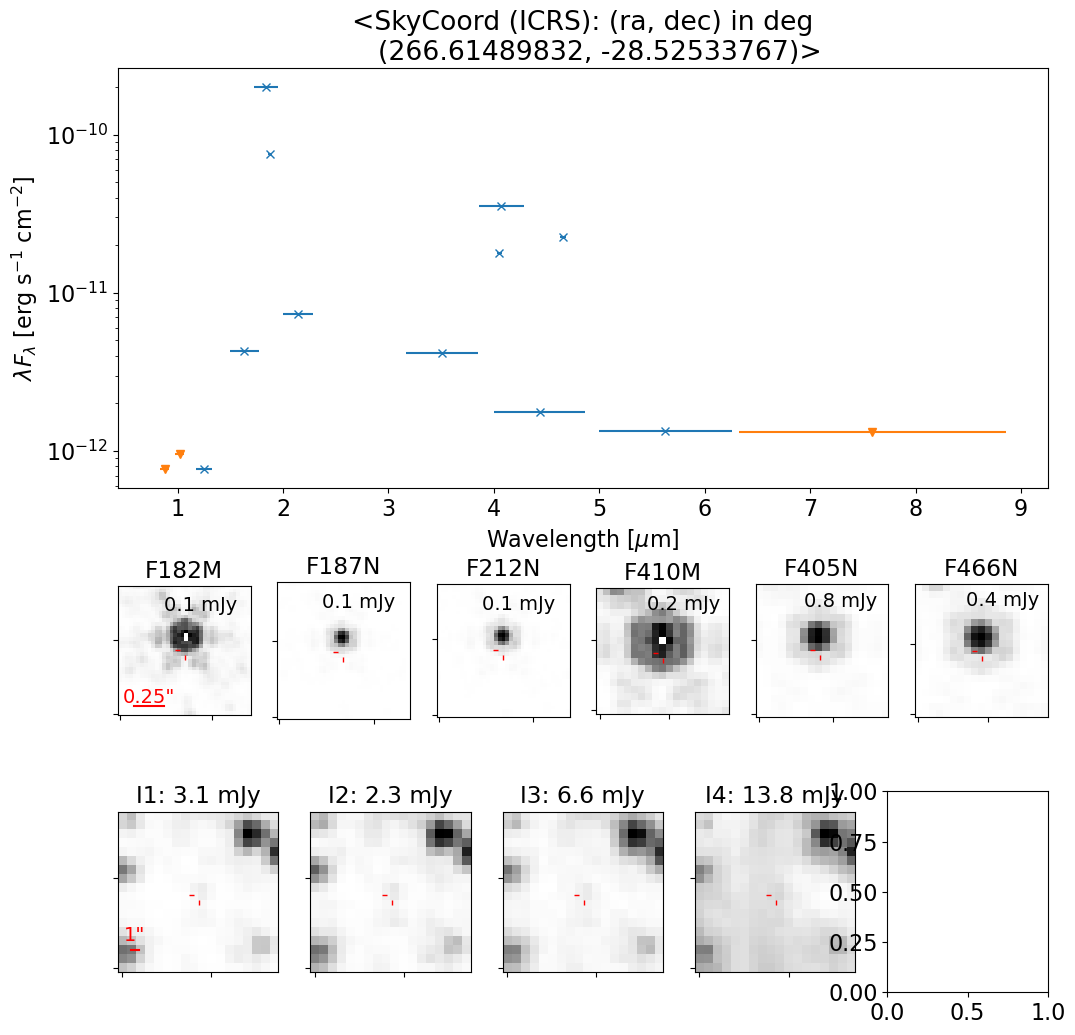

In [22]:
pos = tbl_uses['skycoord_ref'][7]
plot_tools.sed_and_starzoom_plot(pos, basetable, module='merged')

find relevant coord
query spitzer
before plotting


(<Figure size 1200x1200 with 12 Axes>,
 (<Quantity [40723.18416882, 21211.92727483, 46540.47722267, 40515.7589144 ,
             18737.2236792 , 18388.83222416, 35074.83347149, 44365.56289462,
             56280.61670395, 75890.53988232,  8788.60126363, 10196.14246306,
             12480.6187239 , 16347.44281361, 21435.2715929 ] Angstrom>,
  <Quantity [ 4262.85790239,   274.27440341,   535.40523943,   454.87184789,
               236.68645057,  2250.8124937 ,  6836.18018646,  8649.92060205,
             12561.17490202, 25288.49843082,   889.45988901,   870.63251373,
              1542.51159452,  2674.06922586,  2793.83342778] Angstrom>,
  <Quantity [0.0489814 , 0.07088525, 0.03787737, 0.07719922, 0.04352624,
             0.11292183, 0.0041399 , 0.00203797,        nan,        nan,
                    nan,        nan, 0.00024507, 0.0021594 , 0.00511155] Jy>,
  <Quantity [       nan,        nan,        nan,        nan,        nan,
                    nan,        nan,        nan, 0.0017088

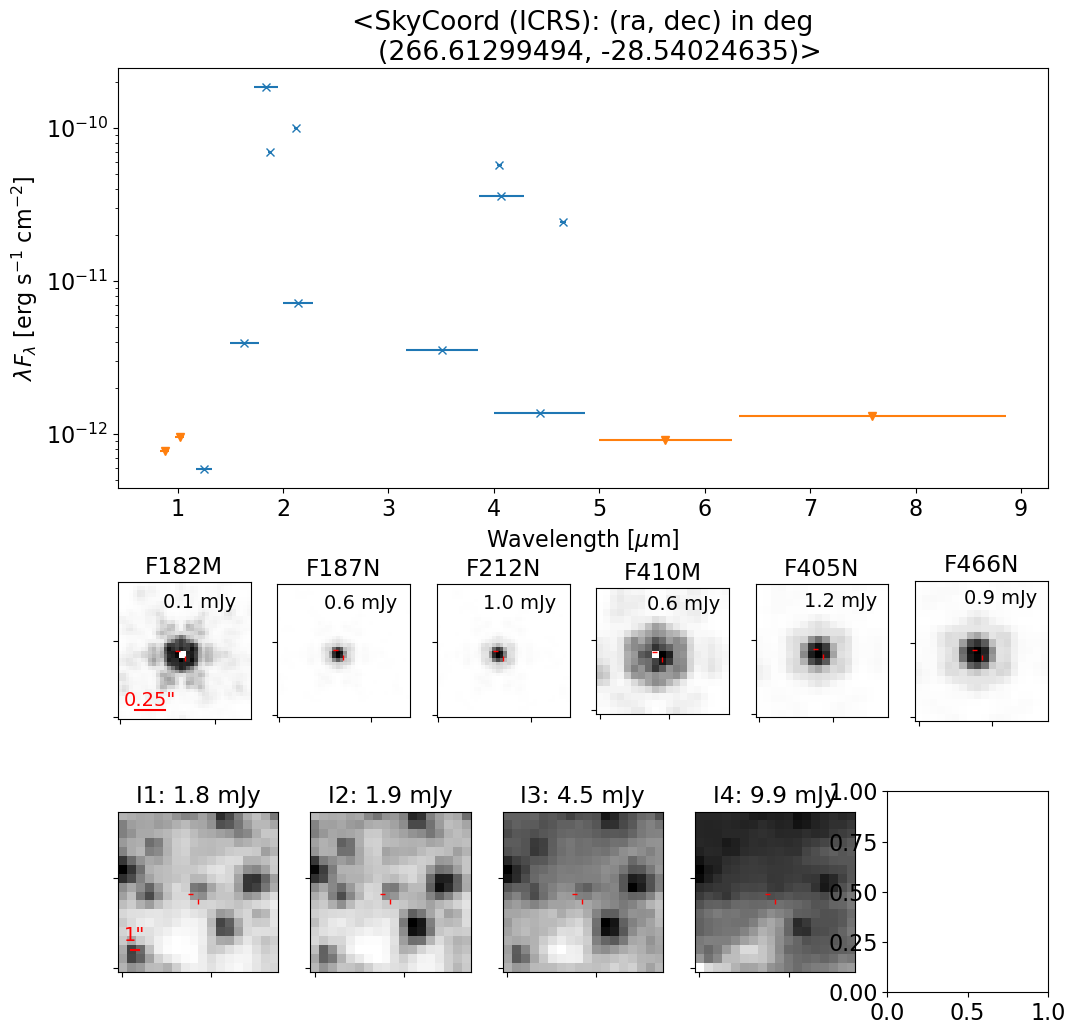

In [23]:
pos = tbl_uses['skycoord_ref'][8]
plot_tools.sed_and_starzoom_plot(pos, basetable, module='merged')

find relevant coord
query spitzer
before plotting


(<Figure size 1200x1200 with 12 Axes>,
 (<Quantity [40723.18416882, 21211.92727483, 46540.47722267, 40515.7589144 ,
             18737.2236792 , 18388.83222416, 35074.83347149, 44365.56289462,
             56280.61670395, 75890.53988232] Angstrom>,
  <Quantity [ 4262.85790239,   274.27440341,   535.40523943,   454.87184789,
               236.68645057,  2250.8124937 ,  6836.18018646,  8649.92060205,
             12561.17490202, 25288.49843082] Angstrom>,
  <Quantity [0.00343104, 0.00634677, 0.0087878 , 0.01838241, 0.00642949,
             0.00527   , 0.00185605,        nan,        nan,        nan] Jy>,
  <Quantity [       nan,        nan,        nan,        nan,        nan,
                    nan,        nan, 0.00108594, 0.00170886, 0.00332107] Jy>))

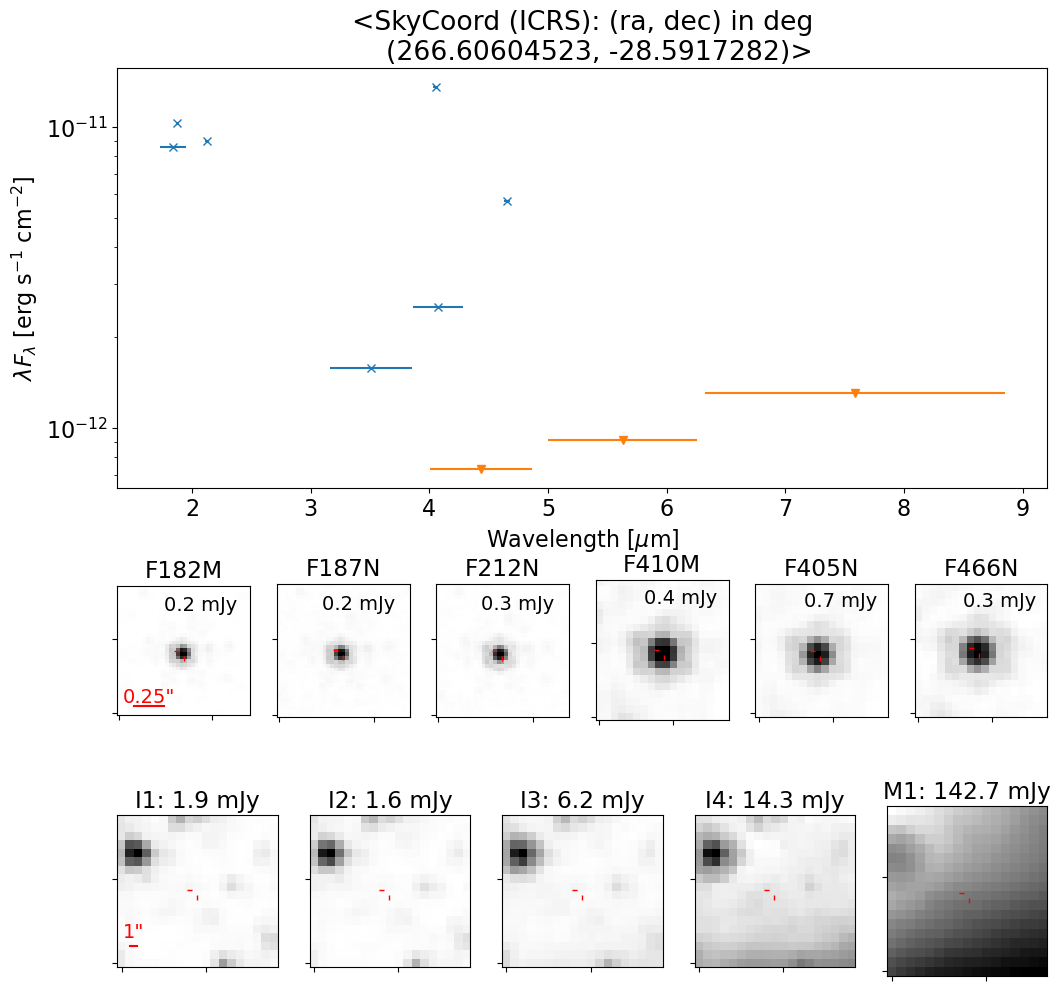

In [24]:
pos = tbl_uses['skycoord_ref'][9]
plot_tools.sed_and_starzoom_plot(pos, basetable, module='merged')

find relevant coord
query spitzer
before plotting


(<Figure size 1200x1200 with 12 Axes>,
 (<Quantity [40723.18416882, 21211.92727483, 46540.47722267, 40515.7589144 ,
             18737.2236792 , 18388.83222416] Angstrom>,
  <Quantity [4262.85790239,  274.27440341,  535.40523943,  454.87184789,
              236.68645057, 2250.8124937 ] Angstrom>,
  <Quantity [6.01485699e-05, 1.16727526e-04, 8.59907959e-05, 1.03615974e-04,
             3.98321863e-05, 1.37893676e-06] Jy>,
  <Quantity [nan, nan, nan, nan, nan, nan] Jy>))

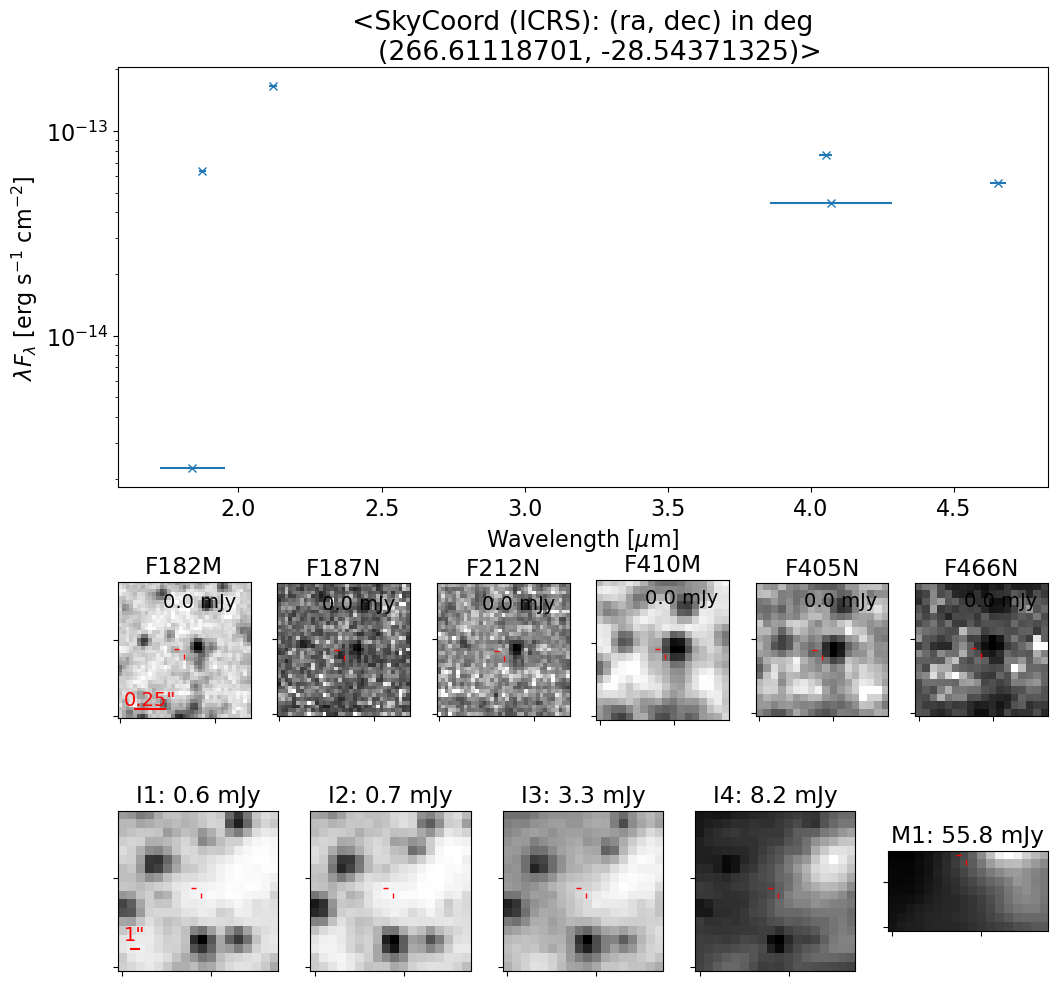

In [25]:
pos = tbl_uses['skycoord_ref'][10]
plot_tools.sed_and_starzoom_plot(pos, basetable, module='merged')

find relevant coord
query spitzer
before plotting


(<Figure size 1200x1200 with 12 Axes>,
 (<Quantity [40723.18416882, 21211.92727483, 46540.47722267, 40515.7589144 ,
             18737.2236792 , 18388.83222416,  8788.60126363, 10196.14246306,
             12480.6187239 , 16347.44281361, 21435.2715929 ] Angstrom>,
  <Quantity [4262.85790239,  274.27440341,  535.40523943,  454.87184789,
              236.68645057, 2250.8124937 ,  889.45988901,  870.63251373,
             1542.51159452, 2674.06922586, 2793.83342778] Angstrom>,
  <Quantity [0.00480146, 0.00681617, 0.00639683, 0.01139146, 0.00227153,
             0.00131174,        nan, 0.00028883, 0.00045761, 0.00066059,
             0.00092502] Jy>,
  <Quantity [       nan,        nan,        nan,        nan,        nan,
                    nan, 0.00022529,        nan,        nan,        nan,
                    nan] Jy>))

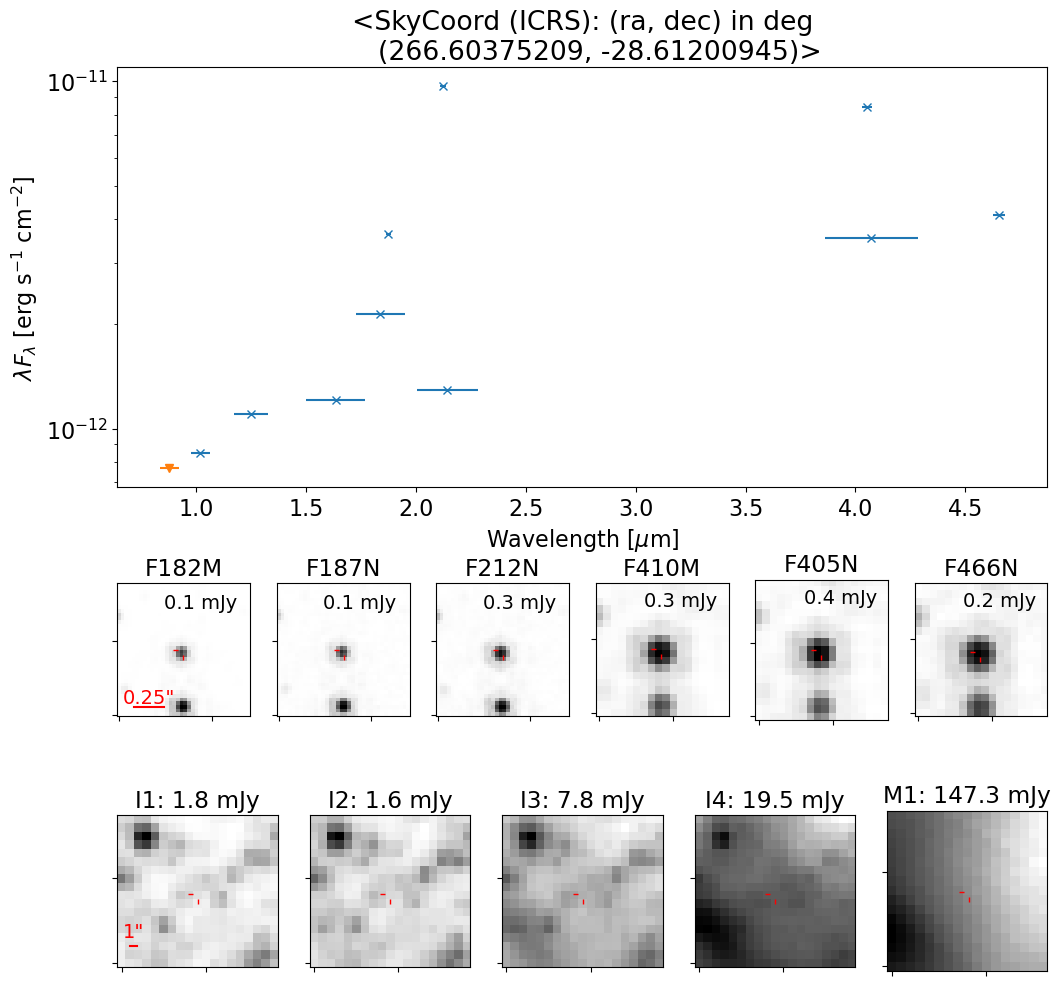

In [26]:
pos = tbl_uses['skycoord_ref'][11]
plot_tools.sed_and_starzoom_plot(pos, basetable, module='merged')

(<Figure size 1200x1200 with 12 Axes>,
 (<Quantity [40723.18416882, 21211.92727483, 46540.47722267, 40515.7589144 ,
             18737.2236792 , 18388.83222416] Angstrom>,
  <Quantity [4262.85790239,  274.27440341,  535.40523943,  454.87184789,
              236.68645057, 2250.8124937 ] Angstrom>,
  <Quantity [0.00000000e+00, 1.01724516e-04, 1.01778278e-04, 1.14534290e-04,
             2.60523484e-05, 1.82846255e-04] Jy>,
  <Quantity [nan, nan, nan, nan, nan, nan] Jy>))

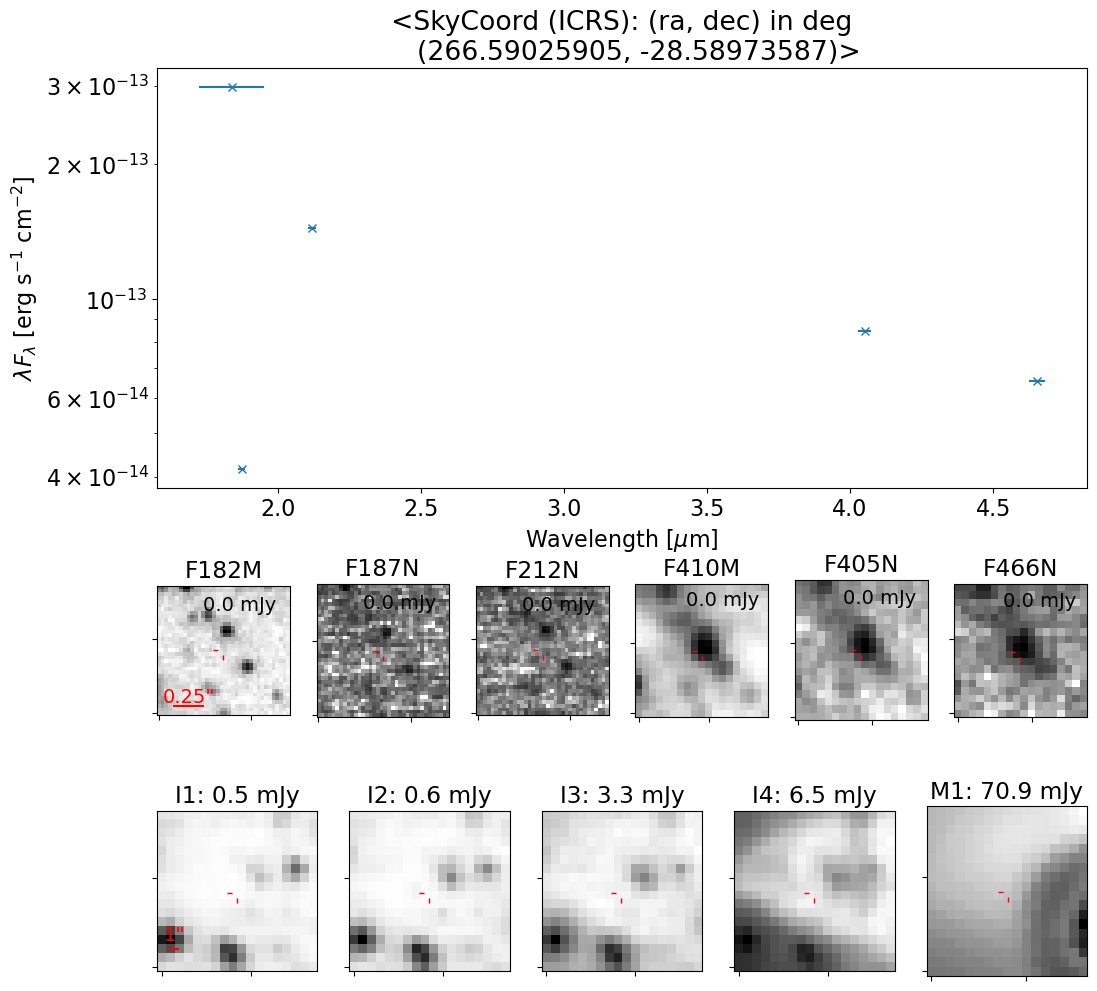

In [8]:
# 60845 - has MIRI counterpart
position = SkyCoord('17:46:21.6621721832', '-28:35:23.0491163244', unit=(u.hourangle, u.deg))
plot_tools.sed_and_starzoom_plot(position, basetable, idx=60845, module='merged')

(<Figure size 1200x1200 with 12 Axes>,
 (<Quantity [40723.18416882, 21211.92727483, 46540.47722267, 40515.7589144 ,
             18737.2236792 , 18388.83222416] Angstrom>,
  <Quantity [4262.85790239,  274.27440341,  535.40523943,  454.87184789,
              236.68645057, 2250.8124937 ] Angstrom>,
  <Quantity [0.00000000e+00, 9.10292729e-05, 6.33467716e-05, 4.92126310e-05,
             4.83695221e-05, 1.80636795e-04] Jy>,
  <Quantity [nan, nan, nan, nan, nan, nan] Jy>))

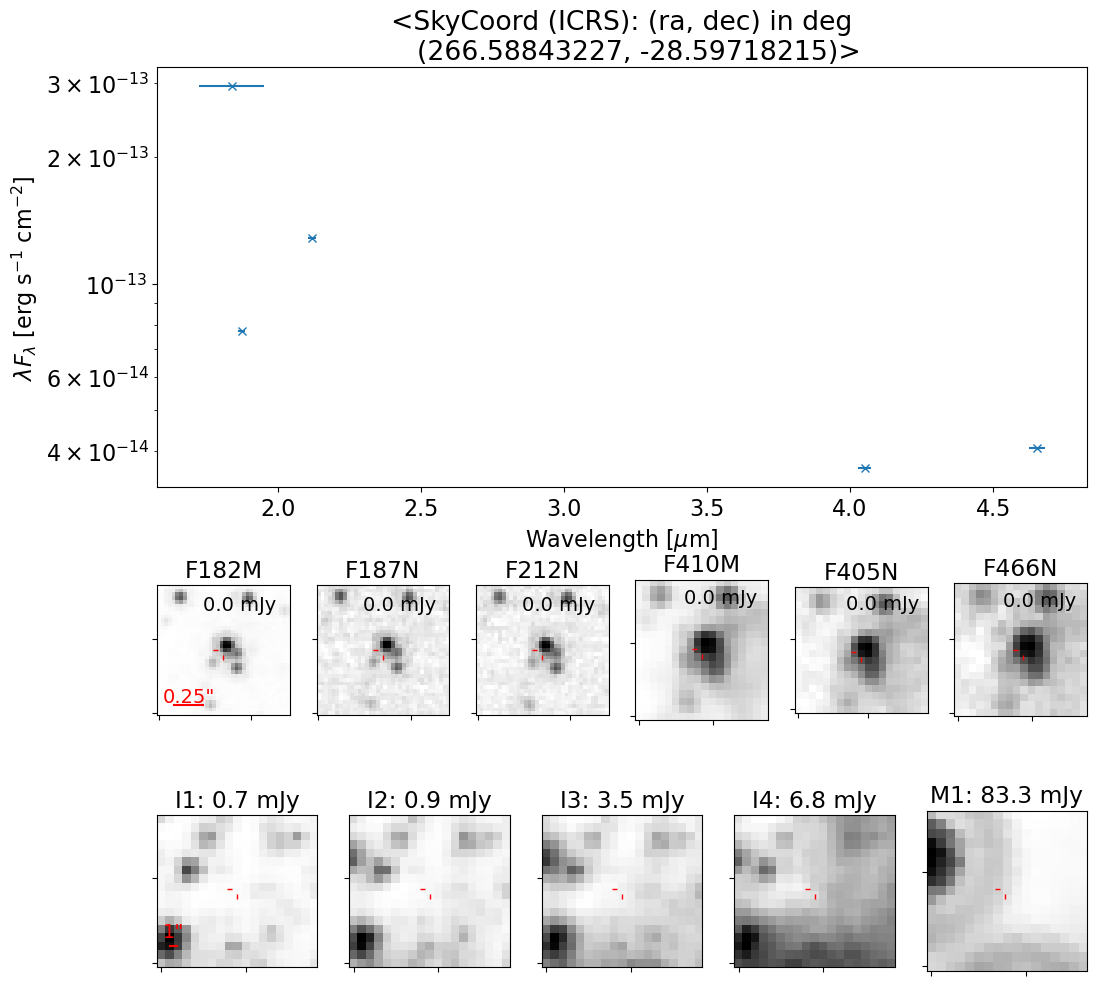

In [9]:
# 152182 - has MIRI counterpart
position = SkyCoord('17:46:21.2237457844', '-28:35:49.8557308583', unit=(u.hourangle, u.deg))
plot_tools.sed_and_starzoom_plot(position, basetable, idx=152182, module='merged')